In [1]:
from data_processing import SDTDataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import v2 as transformsv2
from torch.utils.data import DataLoader
import torch
import numpy as np
from model import UNet
from instance_seg import salt_and_pepper_noise, gaussian_noise
import skimage.io as skio
from skimage.color import label2rgb as label
from skimage.filters import gaussian
from PIL import Image
import tifffile
from data_processing import compute_sdt

In [2]:
# load model from checkpoint
modelpath = '/localscratch/dl4mia-project-segmentation/logs/model_scale3_noise_fmaps64.pth'
model = UNet(
        depth=4,
        in_channels=1,
        out_channels=1,
        final_activation="Tanh",
        num_fmaps=64,
        fmap_inc_factor=2,
        downsample_factor=2,
        padding="same",
        upsample_mode="nearest",
    )
checkpoint = torch.load(modelpath)
model.load_state_dict(checkpoint['model_state_dict'])
model.to('cuda')
model.eval()

UNet(
  (left_convs): ModuleList(
    (0): ConvBlock(
      (conv_pass): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): ConvBlock(
      (conv_pass): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): ConvBlock(
      (conv_pass): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): ConvBlock(
      (conv_pass): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d

In [3]:
train_data = SDTDataset(transform=None, img_transform=None, train=True, ignore_background=False, 
                            center_crop=True, pad=256, watershed_scale=5)
val_data = SDTDataset(train=False, return_mask=True, mean=train_data.mean, std=train_data.std, center_crop=True, pad=256, 
                      ignore_background=False, watershed_scale=5)

In [11]:
im_path = "/group/dl4miacourse/projects/membrane/ecad_gfp/20240408_embryo_1/max_project_NG-ILE-C488-mp.tif"
mask_path = "/group/dl4miacourse/projects/membrane/ecad_gfp/20240408_embryo_1/cell_mesh_mask.tif"

im = tifffile.imread(im_path)[10]
mask = tifffile.imread(mask_path)[10]
im = Image.fromarray(im)
mask = Image.fromarray(mask)
sdt = compute_sdt(mask)

inp_transforms = transforms.Compose(
            [
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize([train_data.mean], [train_data.std]),  # 0.5 = mean and 0.5 = variance
            ]
        )
image = inp_transforms(im)

In [6]:
#retrieve image
idx = 10
image, mask, sdt = val_data[idx]

In [12]:
image = image.to('cuda')
print(image.shape)
# generate prediction from neural network
with torch.no_grad():
    pred = model(image[np.newaxis, ...])

image = np.squeeze(image.cpu())
gt_labels = mask
gt_sdt = sdt
pred = np.squeeze(pred.cpu().detach().numpy())

torch.Size([1, 1200, 1200])


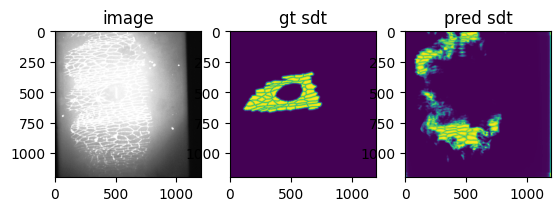

In [13]:
#visualize the outputs
fig, ax = plt.subplots(1, 3)
smooth_pred = gaussian(pred, sigma=1)
ax[0].imshow(image, cmap='Greys_r')
ax[0].set_title('image')
ax[1].imshow(gt_sdt, cmap='viridis')
ax[1].set_title('gt sdt')
ax[2].imshow(smooth_pred, cmap='viridis')
ax[2].set_title('pred sdt')
plt.show()

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

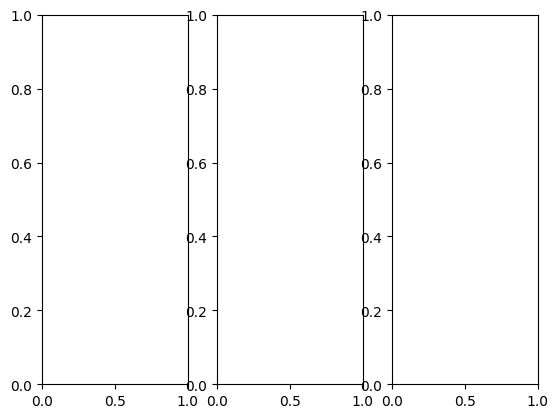

In [8]:
#visualize the outputs
fig, ax = plt.subplots(1, 3)
smooth_pred = pred
# smooth_pred = gaussian(pred, sigma=1)
cropped_img = transforms.CenterCrop(256)(Image.fromarray(image.numpy()))
cropped_pred = transforms.CenterCrop(256)(transforms.ToTensor()(smooth_pred))
cropped_gt = transforms.CenterCrop(256)(transforms.ToTensor()(gt_sdt))
ax[0].imshow(cropped_img, cmap='Greys_r')
ax[0].set_title('image')
ax[1].imshow(cropped_gt.numpy()[0], cmap='viridis')
ax[1].set_title('gt sdt')
ax[2].imshow(cropped_pred.numpy()[0], cmap='viridis')
ax[2].set_title('pred sdt')
plt.show()

In [214]:
# perform a watershed on the predicted sdt mask
from model_evaluation import watershed_from_boundary_distance, get_inner_mask
from skimage.filters import threshold_otsu

# Do watershed and compare to gt mask
threshold = threshold_otsu(smooth_pred)

# Get inner mask
inner_mask = get_inner_mask(smooth_pred, threshold=threshold)

# Get the segmentation
seg = watershed_from_boundary_distance(smooth_pred, inner_mask, min_seed_distance=30)

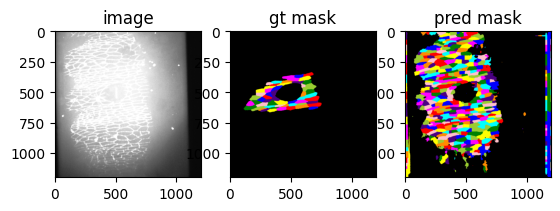

[[ 15  15  15 ...  21  21  21]
 [ 15  15  15 ...  21  21  21]
 [ 15  15  15 ...  21  21  21]
 ...
 [631 631 631 ... 630 630 630]
 [631 631 631 ... 630 630 630]
 [631 631 631 ... 630 630 630]]


In [219]:
#visualize the outputs
%matplotlib inline
fig, ax = plt.subplots(1, 3)
# cropped_seg = transforms.CenterCrop(256)(Image.fromarray(seg))
ax[0].imshow(image, cmap='Greys_r')
ax[0].set_title('image')
ax[1].imshow(label(np.array(gt_labels)))  #, cmap='tab10')
ax[1].set_title('gt mask')
ax[2].imshow(label(seg)) # cmap='tab10')
ax[2].set_title('pred mask')
plt.show()
print(seg)

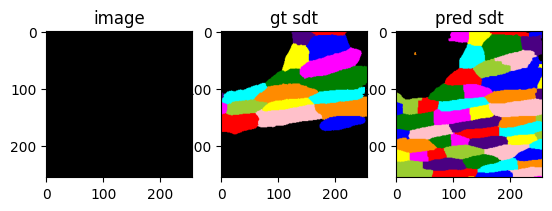

In [200]:
#visualize the outputs
fig, ax = plt.subplots(1, 3)
cropped_img = transforms.CenterCrop(256)(Image.fromarray(image.numpy()))
cropped_seg = transforms.CenterCrop(256)(transforms.ToTensor()(seg))
cropped_gt = transforms.CenterCrop(256)(transforms.ToTensor()(gt_labels))
ax[0].imshow(cropped_img, cmap='Greys_r')
ax[0].set_title('image')
ax[1].imshow(label(cropped_gt.numpy()[0]))
ax[1].set_title('gt sdt')
ax[2].imshow(label(cropped_seg.numpy()[0]))
ax[2].set_title('pred sdt')
plt.show()

In [220]:
# get some metrics to compare
from model_evaluation import evaluate
from sklearn.metrics import mean_squared_error
metrics = dict()
metrics['precision_list'], metrics['recall_list'], metrics['accuracy_list'], metrics['iou_list'], metrics['mse_list'] = [], [], [], [], []
precision, recall, accuracy, iou = evaluate(gt_labels, seg)
metrics['precision_list'].append(precision)
metrics['recall_list'].append(recall)
metrics['accuracy_list'].append(accuracy)
metrics['iou_list'].append(iou)
metrics['mse_list'].append(mean_squared_error(pred.flatten(), gt_sdt.flatten()))

AttributeError: 'Image' object has no attribute 'dtype'

In [221]:
print(f"Precision: {metrics['precision_list'][0]}")
print(f"Recall: {metrics['recall_list'][0]}")
print(f"Accuracy: {metrics['accuracy_list'][0]}")
print(f"MSE: {metrics['mse_list'][0]}")
print(f"Mean IOU: {np.mean(metrics['iou_list'])}")
print(f"Mean TP IOU: {np.mean(metrics['iou_list'][0][metrics['iou_list'][0] > 0.5])}")

IndexError: list index out of range